Số dòng sau làm sạch: 397884
  InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

          InvoiceDate  UnitPrice CustomerID         Country  Revenue  
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom    15.30  
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom    20.34  
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom    22.00  


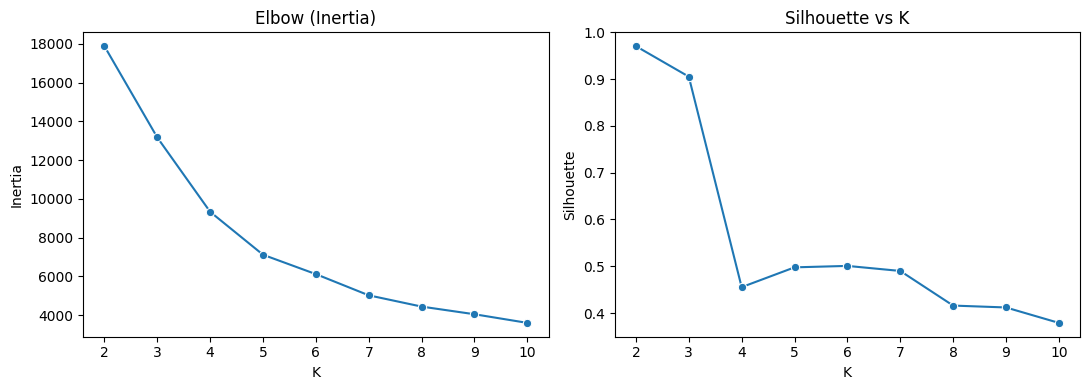

[INFO] Best K by Silhouette = 2, Silhouette = 0.971

Số khách theo cụm:
cluster
0    4336
1       2
Name: count, dtype: int64

Tóm tắt theo cụm:
        recency_days                            frequency                     \
                mean         std min  max count      mean       std min  max   
cluster                                                                        
0           92.50369   99.964702   1  374  4336  4.273293  7.699536   1  209   
1          163.50000  229.809704   1  326     2  1.500000  0.707107   1    2   

               ... avg_items_per_invoice                                  \
        count  ...                  mean           std      min      max   
cluster        ...                                                         
0        4336  ...            227.139133    297.163120      1.0   7824.0   
1           2  ...          57356.750000  23841.165788  40498.5  74215.0   

              unique_items                             
        count    

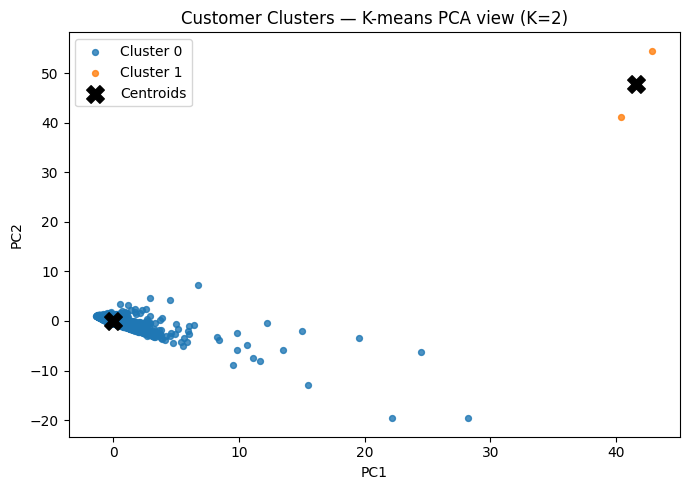

         recency_days       monetary  frequency
cluster                                        
1           163.50000  122828.050000   1.500000
0            92.50369    1998.558995   4.273293


In [2]:
# ============================
# K-means Clustering for Supermarket Transactional Data (Online Retail)
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, sys
warnings.filterwarnings('ignore')

from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# ----------------------------
# 1) Load & Basic Cleaning
# ----------------------------
CSV_PATH = "/kaggle/input/online-retail-customer-clustering/OnlineRetail.csv"  # <-- ĐỔI PATH CHO PHÙ HỢP
# Nếu dữ liệu dùng ; hoặc \t, thêm sep=';'/'\t' tương ứng
df = pd.read_csv(CSV_PATH, encoding='latin-1')

# Chuẩn hoá tên cột
df.columns = [c.strip() for c in df.columns]

required = {'InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country'}
missing = required - set(df.columns)
if missing:
    print("Thiếu cột:", missing)
    sys.exit(1)

# Ép kiểu & parse ngày (định dạng UK thường là 'dd-mm-yyyy hh:mm')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce', dayfirst=True)

# Loại bỏ CustomerID thiếu (không gom được theo khách)
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(str)

# Bỏ hoá đơn huỷ (InvoiceNo bắt đầu bằng 'C')
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df = df[~df['InvoiceNo'].str.startswith('C', na=False)]

# Giữ dòng Quantity>0, UnitPrice>0 (loại outlier âm sau khi bỏ C)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Tạo Revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']

print("Số dòng sau làm sạch:", len(df))
print(df.head(3))

# ----------------------------
# 2) Xây đặc trưng ở mức khách hàng (RFM + basket features)
# ----------------------------
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)  # mốc để tính Recency

grp = df.groupby('CustomerID', as_index=False).agg(
    last_purchase=('InvoiceDate', 'max'),
    frequency=('InvoiceNo', pd.Series.nunique),
    monetary=('Revenue', 'sum'),
    total_qty=('Quantity', 'sum'),
    unique_items=('StockCode', pd.Series.nunique)
)

grp['recency_days'] = (snapshot_date - grp['last_purchase']).dt.days
grp['avg_basket_value'] = grp['monetary'] / grp['frequency'].replace(0, np.nan)
grp['avg_items_per_invoice'] = grp['total_qty'] / grp['frequency'].replace(0, np.nan)

# Chọn các feature để phân cụm (có thể tuỳ chỉnh)
FEATS = ['recency_days', 'frequency', 'monetary', 'avg_basket_value', 'avg_items_per_invoice', 'unique_items']

X = grp[FEATS].fillna(0).copy()

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------
# 3) Chọn K bằng Elbow + Silhouette
# ----------------------------
Ks = range(2, 11)  # từ 2..10 vì silhouette không định nghĩa cho K=1
inertias, sils = [], []

# Dùng n_init an toàn cho mọi version
for k in Ks:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))

fig, ax = plt.subplots(1, 2, figsize=(11,4))
sns.lineplot(x=list(Ks), y=inertias, marker='o', ax=ax[0])
ax[0].set_title('Elbow (Inertia)'); ax[0].set_xlabel('K'); ax[0].set_ylabel('Inertia')

sns.lineplot(x=list(Ks), y=sils, marker='o', ax=ax[1])
ax[1].set_title('Silhouette vs K'); ax[1].set_xlabel('K'); ax[1].set_ylabel('Silhouette')

plt.tight_layout(); plt.show()

best_k = list(Ks)[int(np.argmax(sils))]
print(f"[INFO] Best K by Silhouette = {best_k}, Silhouette = {max(sils):.3f}")

# ----------------------------
# 4) Fit K-means cuối & gán nhãn
# ----------------------------
km_final = KMeans(n_clusters=best_k, init='k-means++', n_init=10, random_state=42)
grp['cluster'] = km_final.fit_predict(X_scaled)

print("\nSố khách theo cụm:")
print(grp['cluster'].value_counts().sort_index())

# ----------------------------
# 5) Profile cụm (thống kê mô tả)
# ----------------------------
profile = grp.groupby('cluster')[FEATS].agg(['mean','std','min','max','count'])
print("\nTóm tắt theo cụm:")
print(profile)

# ----------------------------
# 6) PCA 2D để minh hoạ
# ----------------------------
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_scaled)
centers2 = pca.transform(km_final.cluster_centers_)

plt.figure(figsize=(7,5))
palette = sns.color_palette('tab10', n_colors=best_k)
for c in range(best_k):
    idx = (grp['cluster'] == c)
    plt.scatter(X2[idx,0], X2[idx,1], s=18, alpha=0.8, label=f'Cluster {c}', color=palette[c])
plt.scatter(centers2[:,0], centers2[:,1], s=160, c='k', marker='X', label='Centroids')
plt.title(f'Customer Clusters — K-means PCA view (K={best_k})')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend()
plt.tight_layout(); plt.show()

# ----------------------------
# 7) Gợi ý đặt tên cụm (tuỳ dữ liệu thực tế)
# ----------------------------
# Ví dụ (đơn giản): dựa theo monetary & recency
tmp = grp[['cluster','recency_days','monetary','frequency']].groupby('cluster').mean().sort_values('monetary', ascending=False)
print(tmp)
